In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from math import radians, cos, sin, asin, sqrt

In [2]:
#reading train.csv file#
dftrain = pd.read_csv('train.csv', index_col=False)

In [3]:
#reading climate data file
weather = pd.read_csv('weather.csv', index_col=False)

In [4]:
#for data shape
dftrain.shape
    

(1458644, 11)

# Data Cleaning

City Boundaries, outliers in time duration

In [114]:
dftrain.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_hour,drop_hour,pickup_month,drop_month,pickup_weekday,drop_weekday,distance,maximum Temperature,minimum Temperature,average Temperature,precipitation,snow fall,snow depth
count,1.424814e+06,1.424814e+06,1.424814e+06,1.424814e+06,1.424814e+06,1.424814e+06,1.424814e+06,1.424814e+06,1.424814e+06,1.424814e+06,1.424814e+06,1.424814e+06,1.424814e+06,1.424814e+06,1.424814e+06,1.424814e+06,1.424814e+06,1.424814e+06,1.424814e+06,1.424814e+06
mean,1.534849e+00,1.665181e+00,-7.397428e+01,4.075127e+01,-7.397388e+01,4.075183e+01,8.138770e+02,1.362076e+01,1.361541e+01,3.513391e+00,3.513686e+00,3.049628e+00,3.053724e+00,3.258355e+00,5.936295e+01,4.358186e+01,5.147240e+01,8.593783e-02,6.145293e-02,4.068356e-01
std,4.987843e-01,1.315176e+00,3.608799e-02,2.701934e-02,3.177553e-02,2.937548e-02,5.951538e+02,6.383876e+00,6.465010e+00,1.680799e+00,1.680965e+00,1.954223e+00,1.956573e+00,3.555249e+00,1.696046e+01,1.484428e+01,1.568725e+01,2.496266e-01,9.417261e-01,2.240720e+00
min,1.000000e+00,0.000000e+00,-7.402968e+01,4.063000e+01,-7.403000e+01,4.063000e+01,5.400000e+01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,-1.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399191e+01,4.073763e+01,-7.399131e+01,4.073642e+01,3.970000e+02,9.000000e+00,9.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.232835e+00,4.500000e+01,3.200000e+01,3.850000e+01,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,1.000000e+00,-7.398182e+01,4.075421e+01,-7.397989e+01,4.075457e+01,6.560000e+02,1.400000e+01,1.400000e+01,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,2.071825e+00,5.900000e+01,4.400000e+01,5.150000e+01,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000e+00,2.000000e+00,-7.396770e+01,4.076836e+01,-7.396363e+01,4.076958e+01,1.053000e+03,1.900000e+01,1.900000e+01,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,3.753202e+00,7.300000e+01,5.400000e+01,6.300000e+01,4.000000e-02,0.000000e+00,0.000000e+00
max,2.000000e+00,6.000000e+00,-7.375282e+01,4.085000e+01,-7.375000e+01,4.085000e+01,4.081000e+03,2.300000e+01,2.300000e+01,6.000000e+00,7.000000e+00,6.000000e+00,6.000000e+00,2.719163e+01,9.200000e+01,7.300000e+01,8.150000e+01,2.310000e+00,2.730000e+01,2.200000e+01


In [5]:
#Longitude, Latitude cleanup wrt city borders
def boundaries(df):
    df = df[df['pickup_longitude'] <= -73.75]
    df = df[df['pickup_longitude'] >= -74.03]
    df = df[df['pickup_latitude'] <= 40.85]
    df = df[df['pickup_latitude'] >= 40.63]
    df = df[df['dropoff_longitude'] <= -73.75]
    df = df[df['dropoff_longitude'] >= -74.03]
    df = df[df['dropoff_latitude'] <= 40.85]
    df = df[df['dropoff_latitude'] >= 40.63]
    return df

In [6]:
dftrain = boundaries(dftrain)

In [7]:
#Trip duration cleanup -
def cleanduration(df):
    limits  = [np.percentile(df['trip_duration'], 0.5), np.percentile(df['trip_duration'], 99.5)]
    df1=df[(df.trip_duration >= limits[0] ) & (df.trip_duration <= limits[1])]
    return df1

In [8]:
dftrain = cleanduration(dftrain)

In [9]:
dftrain.shape

(1424814, 11)

# Factor Extraction

# Extracting features from Timestamp

In [10]:
#Changing time stamp format
def timedtype(df):
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['dropoff_datetime']= pd.to_datetime(df['dropoff_datetime'])
    return df

In [11]:
dftrain = timedtype(dftrain)

In [12]:
#Extracting individual parameters from fatestamp
def dateextract(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['drop_date'] = df['dropoff_datetime'].dt.date

    df['pickup_time'] = df['pickup_datetime'].dt.time
    df['drop_time'] = df['dropoff_datetime'].dt.time

    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['drop_hour'] = df['dropoff_datetime'].dt.hour

    df['pickup_month'] = df['pickup_datetime'].dt.month
    df['drop_month'] = df['dropoff_datetime'].dt.month

    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
    df['drop_weekday'] = df['dropoff_datetime'].dt.weekday
    
    df['yday'] = df['pickup_datetime'].dt.dayofyear

In [13]:
dateextract(dftrain)

In [14]:
dftrain.shape

(1424814, 22)

# Distance calculation

In [15]:
#Calculating Distance between Co-ordinates
#Distance calculation
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km
def distance(df):
    df['distance'] = df.apply(lambda x: haversine(x.pickup_longitude,x.pickup_latitude,x.dropoff_longitude,x.dropoff_latitude), axis=1)

In [16]:
distance(dftrain)

In [17]:
dftrain.shape

(1424814, 23)

# Adding weather Data

In [18]:
#adding weather data
def addingweather(df):
    weather['date'] = pd.to_datetime(weather['date'])
    df['pickup_date'] = pd.to_datetime(df['pickup_date'])
    weather.rename(columns={'date':'pickup_date'},inplace=True)
    df=pd.merge(df,weather,on='pickup_date',how='left')
    return df


In [19]:
dftrain = addingweather(dftrain)

In [20]:
#to csv after extracting facttors: change file name after using function
def tocsv(df):
    df.to_csv("dfwithfactors.csv")
    

In [21]:
tocsv(dftrain)

# Grouping the categorical values based on similar behaviour

# Number of trips by month

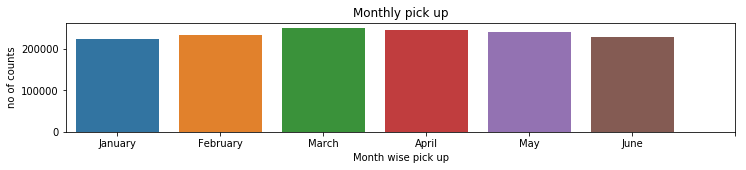

In [22]:
#Monthly
month_names=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
plt.figure(figsize=(12,2))
month_wise=dftrain.groupby('pickup_month').agg({'id':'count'}).reset_index()
sns.barplot(x='pickup_month',y='id',data=month_wise)
plt.xlabel('Month wise pick up')
plt.ylabel('no of counts')
plt.xticks(range(0,7),month_names[:6])
plt.title('Monthly pick up')
pass

Lower number of trips in first two months may be due to "Winter". Next 3 months are showing similar behavior with number of trips. So, we are grouping months into three seasons

In [23]:
#For the train dataset, devide months into seasons
def season(dfv4):
    dfv4['s1']=dfv4['pickup_month']<=2
    dfv4['s2']=dfv4['pickup_month'].between(3,5)
    dfv4['s3']=dfv4['pickup_month']>=6

In [24]:
season(dftrain)

# Number of trips by week day

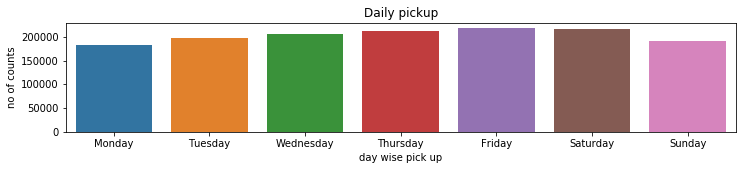

In [25]:
#Day of a week
weekday_names=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12,2))
day_wise=dftrain.groupby('pickup_weekday').agg({'id':'count'}).reset_index()
sns.barplot(x='pickup_weekday',y='id',data=day_wise)
plt.xlabel('day wise pick up')
plt.ylabel('no of counts')
plt.xticks(range(0,7),weekday_names)
plt.title('Daily pickup')
pass


There is no particular trend in weekday vs number of trips. so, we take week days as individual features

In [26]:
def weekdaydummy(dfv4):
    dfv4["pwd0"] = dfv4['pickup_weekday']==0
    dfv4["pwd1"] = dfv4['pickup_weekday']==1
    dfv4["pwd2"] = dfv4['pickup_weekday']==2
    dfv4["pwd3"] = dfv4['pickup_weekday']==3
    dfv4["pwd4"] = dfv4['pickup_weekday']==4
    dfv4["pwd5"] = dfv4['pickup_weekday']==5
    dfv4["pwd6"] = dfv4['pickup_weekday']==6

In [27]:
weekdaydummy(dftrain)

In [28]:
def weekdaydist(dfv4):
    dfv4["weektime"] = dfv4['pickup_weekday'].between(0,4)
    dfv4["weekendtime"] = dfv4['pickup_weekday'].between(5,6)

In [29]:
weekdaydist(dftrain)

We tried grouping week days, but it is showing negative effect on ML model. So, we withdrew the approach on weekday grouping

# Number of trips by hour of the day

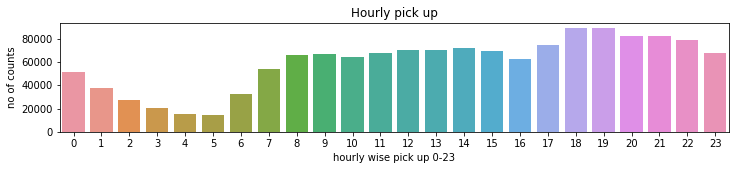

In [30]:
#Hourly
plt.figure(figsize=(12,2))
hour_wise=dftrain.groupby('pickup_hour').agg({'id':'count'}).reset_index()
sns.barplot(x='pickup_hour',y='id',data=hour_wise)
plt.xlabel('hourly wise pick up 0-23')
plt.ylabel('no of counts')
plt.title('Hourly pick up')
pass

As we see some similarity in behaviour through some time periods, we divided the whole day into 4 time zones

In [31]:
def timebins(dfv4):
    dfv4['timeperiod1']=dfv4['pickup_hour'].between(0,6)
    dfv4['timeperiod2']=dfv4['pickup_hour'].between(7,10)
    dfv4['timeperiod3']=dfv4['pickup_hour'].between(11,16)
    dfv4['timeperiod4']=dfv4['pickup_hour'].between(17,23)

In [32]:
timebins(dftrain)

# Number of Passengers vs Average trip duration

Text(0.5,1,u'passenger count - trip duration')

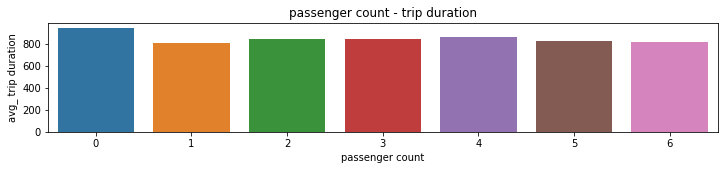

In [33]:
#Number of Passengers vs Average trip duration
plt.figure(figsize=(12,2))
passenger=dftrain.groupby('passenger_count').agg({'trip_duration':'mean'}).reset_index()
sns.barplot(x='passenger_count',y='trip_duration',data=passenger)
plt.xlabel('passenger count')
plt.ylabel('avg_ trip duration')
plt.title('passenger count - trip duration')

In [ ]:
As there is no much effect of number of passengers on trip duration, we are not considering 

# Extracting relavent features from weather Weather

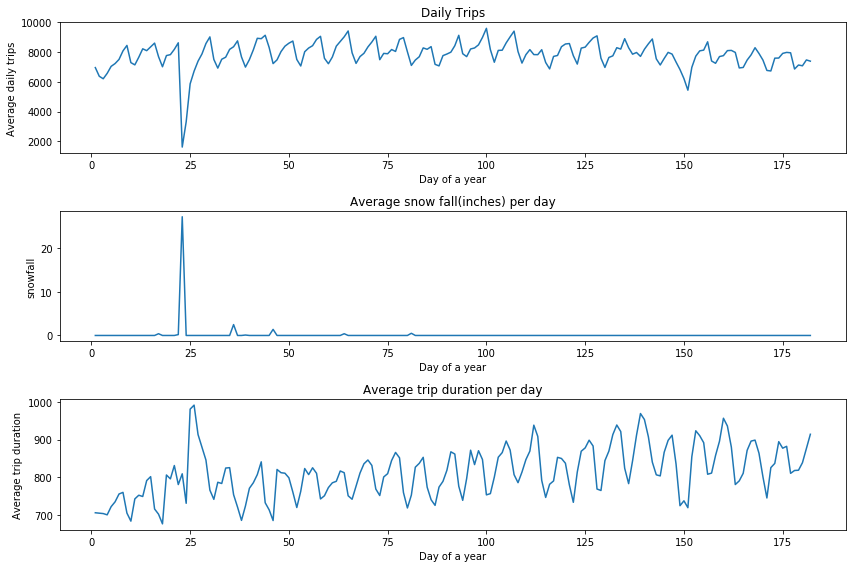

In [47]:
#Weather data comarison
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12, 8))

figure=plt.subplot(311)
table=dftrain.groupby('yday').agg({'id':'count'})
plt.plot(table)
plt.xlabel('Day of a year')
plt.ylabel('Average daily trips')
plt.title('Daily Trips')
pass

figure=plt.subplot(312)
data=dftrain.groupby('yday').agg({'snow fall':'mean'})
plt.xlabel('Day of a year')
plt.ylabel('snowfall')
plt.title('Average snow fall(inches) per day')
plt.plot(data)
pass

figure=plt.subplot(313)
data=dftrain.groupby('yday').agg({'trip_duration':'mean'})
plt.xlabel('Day of a year')
plt.ylabel('Average trip duration')
plt.title('Average trip duration per day')
plt.plot(data)
pass

fig.tight_layout()

As we see the graphs above, when there was snow fall, there was a drop in number of trips and increase in average trip duration. So, we take snow fall a feature

In [35]:
dftrain.columns

Index([u'id', u'vendor_id', u'pickup_datetime', u'dropoff_datetime',
       u'passenger_count', u'pickup_longitude', u'pickup_latitude',
       u'dropoff_longitude', u'dropoff_latitude', u'store_and_fwd_flag',
       u'trip_duration', u'pickup_date', u'drop_date', u'pickup_time',
       u'drop_time', u'pickup_hour', u'drop_hour', u'pickup_month',
       u'drop_month', u'pickup_weekday', u'drop_weekday', u'yday', u'distance',
       u'maximum Temperature', u'minimum Temperature', u'average Temperature',
       u'precipitation', u'snow fall', u'snow depth', u's1', u's2', u's3',
       u'pwd0', u'pwd1', u'pwd2', u'pwd3', u'pwd4', u'pwd5', u'pwd6',
       u'weektime', u'weekendtime', u'timeperiod1', u'timeperiod2',
       u'timeperiod3', u'timeperiod4'],
      dtype='object')

# Selecting relavant features

In [36]:
features = ["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count",u'pwd0', 'pwd1', 'pwd2', 'pwd3', 'pwd4', 'pwd5',
       'pwd6',"distance","snow fall","s1","s2","s3",'timeperiod1', 'timeperiod2', 'timeperiod3', 'timeperiod4']

In [37]:
x = dftrain[features]
Y = dftrain['trip_duration']
x=sm.add_constant(x)
model=sm.OLS(Y,x.astype(float)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                 1.338e+05
Date:                Fri, 08 Dec 2017   Prob (F-statistic):               0.00
Time:                        18:03:42   Log-Likelihood:            -1.0419e+07
No. Observations:             1424814   AIC:                         2.084e+07
Df Residuals:                 1424795   BIC:                         2.084e+07
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.279e+05    807.049   -158.446      0.000   -1.29e+05   -1.26e+05
pickup_longitude  -1393.0098     10.166   -137.030      0.000   -1412.934   -1373.085
pickup_latitude    1111.8616     13.261     83.847      0.000    1085.871    1137.852
dropoff_longitude -1487.0512     11.015   -134.998      0.000   -1508.641   -1465.461
dropoff_latitude   -915.3967     11.856    -77.208      0.000    -938.635    -892.159
passenger_count       3.3694      0.231     14.570      0.000       2.916       3.823
pwd0              -1.831e+04    115.287   -158.853      0.000   -1.85e+04   -1.81e+04
pwd1              -1.824e+04    115.294   -158.228      0.000   -1.85e+04    -1.8e+04
pwd2              -1.822e+04    115.297   -158.032      0.000   -1.84e+04    -1.8e+04
pwd3              -1.821e+04    115.296   -157.949      0.000   -1.84e+04    -1.8e+04
pwd4              -1.823e+04    115.294   -158.121      0.000   -1.85e+04    -1.8e+04
pwd5               -1.83e+04    115.302   -158.698      0.000   -1.85e+04   -1.81e+04
pwd6              -1.836e+04    115.296   -159.220      0.000   -1.86e+04   -1.81e+04
distance            144.3228      0.118   1220.660      0.000     144.091     144.555
snow fall             6.0460      0.325     18.583      0.000       5.408       6.684
s1                -4.266e+04    269.015   -158.582      0.000   -4.32e+04   -4.21e+04
s2                -4.262e+04    269.018   -158.431      0.000   -4.31e+04   -4.21e+04
s3                -4.259e+04    269.017   -158.325      0.000   -4.31e+04   -4.21e+04
timeperiod1       -3.213e+04    201.735   -159.280      0.000   -3.25e+04   -3.17e+04
timeperiod2       -3.192e+04    201.776   -158.219      0.000   -3.23e+04   -3.15e+04
timeperiod3       -3.185e+04    201.770   -157.835      0.000   -3.22e+04   -3.15e+04
timeperiod4       -3.197e+04    201.772   -158.449      0.000   -3.24e+04   -3.16e+04
==============================================================================
Omnibus:                   428483.403   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2455249.960
Skew:                           1.330   Prob(JB):                         0.00
Kurtosis:                       8.855   Cond. No.                     1.74e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.76e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [38]:
features = ["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count",'weektime','weekendtime',"distance","snow fall","s1","s2","s3",'timeperiod1', 'timeperiod2', 'timeperiod3', 'timeperiod4']
X_train = dftrain[features]
y_train = dftrain['trip_duration']

In [39]:
X_Train,X_test,Y_train,Y_test=train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [40]:
lm=linear_model.LinearRegression()
model=lm.fit(X_train,y_train)
pred=lm.predict(X_test)
accuracy=round(lm.score(X_train,y_train)*100,2)
accuracy

62.52

In [55]:
Y_test = Y_test.astype(float)

In [59]:
Yt=Y_test.values

In [61]:
pred

array([  628.5703125,   544.6953125,   278.8515625, ...,   443.2109375,
        1090.3515625,   841.5234375])

In [64]:
acc = (Yt-pred)

In [66]:
acc[1] 

-316.6953125

In [80]:
def classification(df1,df2):
    a = []
    i=0
    for i in range (0,len(df1)):
        if abs(df1[i])<abs(df2[i]*0.3):
            a.append(1)
        else:
            a.append(0)
    return a

In [81]:
classarray = classification(acc,Yt)

In [82]:
classarray.count(1)

146802

In [83]:
classarray.count(0)

138161

In [69]:
def sumofsq(df):
    a = 0
    i=0
    for i in range (0,len(df)):
        a = a+(df[i])**2
        i=i+1
        
    return a
    
    
    

In [70]:
acc12 = sumofsq(acc)

In [72]:
acc12/len(acc)

132308.3896632097

In [62]:
from sklearn.metrics import accuracy_score
accuracy_score(Yt, pred)

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets